# **GMVAE**
 (**pytorch**)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os, sys
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import time
from torch.utils.data import DataLoader, TensorDataset
import requests
from pathlib import Path

# Plotting Packages
import matplotlib.pyplot as plt
from matplotlib.colors import BoundaryNorm
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import ListedColormap
from matplotlib.patches import FancyArrowPatch

!pip install mdtraj;

import mdtraj as md

from sklearn.cluster import KMeans
from sklearn.utils import shuffle
from sklearn.preprocessing import MinMaxScaler, StandardScaler


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 77.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 40.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 70.7 MB/s eta 0:00:00


In [61]:
class GMVAE(nn.Module):
    def __init__(self, k, n_z, n_x, qy_dims, qz_dims, pz_dims, px_dims, r_nent, batch_size, lr, use_batch_norm=False):
        super(GMVAE, self).__init__()
        self.k = k
        self.n_z = n_z
        self.n_x = n_x
        self.r_nent = r_nent
        self.batch_size = batch_size
        self.lr = lr

        # y transformation layer
        self.y_transform = nn.Linear(self.k, self.k)

        # Building the Qy network
        qy_layers = []
        previous_dim = self.n_x
        for hidden_dim in qy_dims:
            qy_layers.append(nn.Linear(previous_dim, hidden_dim, bias=not use_batch_norm))
            qy_layers.append(nn.ReLU())
            if use_batch_norm:
                qy_layers.append(nn.BatchNorm1d(hidden_dim, affine=True))
            previous_dim = hidden_dim
        qy_layers.append(nn.Linear(previous_dim, k))
        qy_layers.append(nn.ReLU())
        self.qy_nn = nn.Sequential(*qy_layers)

        # Building the Qz network
        qz_layers = []
        previous_dim = self.k + self.n_x
        for hidden_dim in qz_dims:
            qz_layers.append(nn.Linear(previous_dim, hidden_dim))
            qz_layers.append(nn.ReLU())
            if use_batch_norm:
                qz_layers.append(nn.BatchNorm1d(hidden_dim, affine=True))
            previous_dim = hidden_dim
        self.qz_nn = nn.Sequential(*qz_layers)
        self.zm_layer = nn.Linear(previous_dim, n_z)
        self.zv_layer = nn.Linear(previous_dim, n_z)

        # Building the Pz network
        pz_layers = []
        previous_dim = self.k
        for hidden_dim in pz_dims:
            pz_layers.append(nn.Linear(previous_dim, hidden_dim))
            pz_layers.append(nn.ReLU())
            if use_batch_norm:
                pz_layers.append(nn.BatchNorm1d(hidden_dim, affine=True))
            previous_dim = hidden_dim
        self.pz_nn = nn.Sequential(*pz_layers)
        self.zm_prior_layer = nn.Linear(previous_dim, n_z)
        self.zv_prior_layer = nn.Linear(previous_dim, n_z)

        # Building the Px network
        px_layers = []
        previous_dim = self.n_z
        for hidden_dim in px_dims:
            px_layers.append(nn.Linear(previous_dim, hidden_dim, bias=not use_batch_norm))
            px_layers.append(nn.ReLU())
            if use_batch_norm:
                px_layers.append(nn.BatchNorm1d(hidden_dim, affine=True))
            previous_dim = hidden_dim
        self.px_nn = nn.Sequential(*px_layers)
        self.xm_layer = nn.Linear(previous_dim, n_x)
        self.xv_layer = nn.Linear(previous_dim, n_x)

    @staticmethod
    def log_normal(x, mu, var, eps=1e-10):
        return -0.5 * torch.sum(torch.log(torch.tensor(2.0) * torch.pi) + (x - mu).pow(2) / var + var.log(), dim=-1)

    def loss_function(self, k, x, xm, xv, z, zm, zv, zm_prior, zv_prior):
        return (
            -self.log_normal(x, xm, xv)
            + self.log_normal(z, zm, zv)
            - self.log_normal(z, zm_prior, zv_prior)
            - torch.log(torch.tensor(1/self.k, device=x.device))
        )

    def forward(self, data):

        qy_logit = self.qy_nn(data)
        qy = torch.softmax(qy_logit, dim=1)

        # for enumerating components
        y_ = torch.zeros([data.shape[0], self.k]).to(data.device)

        zm_list, zv_list, z_list = [], [], []
        xm_list, xv_list, x_list = [], [], []
        zm_prior_list, zv_prior_list = [], []

        for i in range(self.k):
            # One-hot y
            y = y_ + torch.eye(self.k).to(data.device)[i]

            # Qz
            h0 = self.y_transform(y)
            xy = torch.cat([data, h0], dim=1)
            qz_logit = self.qz_nn(xy)
            zm = self.zm_layer(qz_logit)
            zv = torch.nn.functional.softplus(self.zv_layer(qz_logit))
            noise = torch.randn_like(torch.sqrt(zv))
            z_sample = zm + noise * zv

            # Store
            zm_list.append(zm)
            zv_list.append(zv)
            z_list.append(z_sample)

            # Pz (prior)
            pz_logit = self.pz_nn(y)
            zm_prior = self.zm_prior_layer(pz_logit)
            zv_prior = torch.nn.functional.softplus(self.zv_prior_layer(pz_logit))
            noise = torch.randn_like(torch.sqrt(zv_prior))
            z_prior_sample = zm_prior + noise * zv_prior

            zm_prior_list.append(zm_prior)
            zv_prior_list.append(zv_prior)

            # Px
            px_logit = self.px_nn(z_prior_sample)
            xm = self.xm_layer(px_logit)
            xv = torch.nn.functional.softplus(self.xv_layer(px_logit))
            noise = torch.randn_like(torch.sqrt(xv))
            x_sample = xm + noise * xv

            xm_list.append(xm)
            xv_list.append(xv)
            x_list.append(x_sample)

        nent = -torch.sum(qy * torch.log_softmax(qy_logit, dim=1), dim=1).mean()

        losses = [None] * self.k

        for i in range(self.k):
            losses[i] = self.loss_function(self.k, data, xm_list[i], xv_list[i],
                                        z_list[i], zm_list[i], zv_list[i],
                                        zm_prior_list[i], zv_prior_list[i])

        # Weighted mixture + negative entropy
        total_loss = sum([self.r_nent*nent]+[qy[:,i]*losses[i] for i in range(self.k)])

        return qy, qy_logit, z_list, x_list, total_loss, nent



In [76]:
traj_apo = md.load("/content/drive/MyDrive/PhD/AI-ML/GMVAE/WT_apo_CA_ChainsA_fit.xtc",
              top="/content/drive/MyDrive/PhD/AI-ML/AE/Results/WT_apo_CA_ChainsA/nl6_z3_ep200_lr0.0001_lrstep50_gamma0.5_dt1/WT_apo_CA_ChainsA.pdb")

data = traj_apo.xyz
#data=data[::2, 85:431, :]

data = np.reshape(data, (data.shape[0], -1))

scaler = MinMaxScaler(feature_range=(-1, 1))
data = scaler.fit_transform(data)

# Instantiate the GMVAE model
train_data = torch.FloatTensor(torch.FloatTensor(data))

train_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = 1551,
                                                drop_last=True,
                                                shuffle = True)
test_dataloader = torch.utils.data.DataLoader(dataset = train_data,
                                                batch_size = 1551,
                                                drop_last=False,
                                                shuffle = False)

In [4]:
# Hyperparameters
k, n_x, n_z, n_epochs = 5, data.shape[1], 2, 100
qy_dims = [32]
qz_dims = [16, 16]
pz_dims = [16, 16]
px_dims = [128]
r_nent = 0.5
batch_size = 1551
lr = 1e-4
train_model = True
partition = 0.8
dt = 1
seed = 42

In [62]:
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)  # If using multiple GPUs
np.random.seed(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GMVAE(k, n_z, n_x, qy_dims, qz_dims, pz_dims, px_dims, r_nent, batch_size, lr, use_batch_norm=False)
model.to(device)
print(model)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)


GMVAE(
  (y_transform): Linear(in_features=5, out_features=5, bias=True)
  (qy_nn): Sequential(
    (0): Linear(in_features=1551, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=5, bias=True)
    (3): ReLU()
  )
  (qz_nn): Sequential(
    (0): Linear(in_features=1556, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (zm_layer): Linear(in_features=16, out_features=2, bias=True)
  (zv_layer): Linear(in_features=16, out_features=2, bias=True)
  (pz_nn): Sequential(
    (0): Linear(in_features=5, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
  )
  (zm_prior_layer): Linear(in_features=16, out_features=2, bias=True)
  (zv_prior_layer): Linear(in_features=16, out_features=2, bias=True)
  (px_nn): Sequential(
    (0): Linear(in_features=2, out_features=128, bias=True)
    (1): ReLU()
  )
  (xm_layer): Lin

In [6]:

# Hidden Variable aggregation
def sum_aggregation(xz_list, qy):
    a = np.zeros(xz_list[0].shape)
    for a_i in range(xz_list[0].shape[1]):
        for y_i in range(qy.shape[1]):
            a[:, a_i] += xz_list[y_i][:,a_i]*qy[:,y_i]
    return a


In [63]:

def train_model(model, train_dataset, epochs, optimizer):
    train_losses = []
    sys.stdout.write("Start Training: \n")
    model.train()
    for epoch in range(epochs):
        start_time = time.time()
        epoch_train_loss = 0.0

        # Training loop
        for _, x_batch_train in enumerate(train_dataset):
            x_batch_train = x_batch_train.to(device)
            _, _, _, _, loss, nent = model(x_batch_train)  # Assuming this returns a loss as one of its outputs
            train_loss = loss.mean()
            optimizer.zero_grad()
            train_loss.backward()  # Calculate gradients
            optimizer.step()  # Update weights
            epoch_train_loss += train_loss

        avg_train_loss = epoch_train_loss / len(train_dataset)
        train_losses.append(avg_train_loss.detach().cpu().numpy())

        if epoch % 10 == 0 or epoch == 0:
            epoch_duration = time.time() - start_time
            sys.stdout.write(f"Epoch {epoch+1}/{epochs} | Train Loss: {avg_train_loss:.2f} | Duration: {epoch_duration:.2f}s \n")

    return train_losses

train_loss = train_model(model, train_dataloader, n_epochs, optimizer)

Start Training: 
Epoch 1/100 | Train Loss: 1144.81 | Duration: 4.01s 
Epoch 11/100 | Train Loss: -287.82 | Duration: 4.16s 
Epoch 21/100 | Train Loss: -342.46 | Duration: 4.14s 
Epoch 31/100 | Train Loss: -374.15 | Duration: 4.13s 
Epoch 41/100 | Train Loss: -385.34 | Duration: 4.12s 
Epoch 51/100 | Train Loss: -427.86 | Duration: 4.21s 
Epoch 61/100 | Train Loss: -433.13 | Duration: 4.11s 
Epoch 71/100 | Train Loss: -433.73 | Duration: 4.08s 
Epoch 81/100 | Train Loss: -434.19 | Duration: 4.15s 
Epoch 91/100 | Train Loss: -434.44 | Duration: 4.20s 


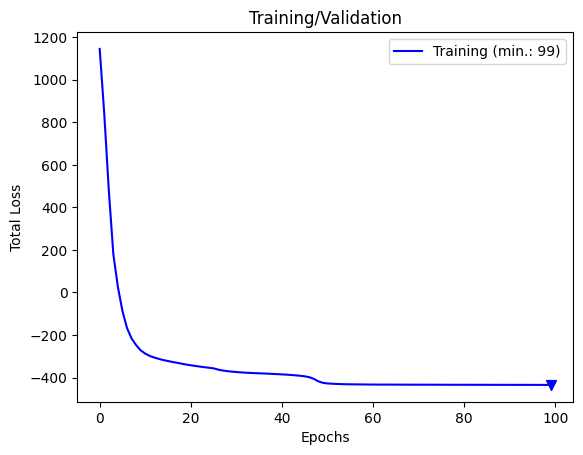

In [64]:
#Training/Validation Plot: Loss vs Epoch
# Finding the minimum value points for train and validation losses
min_train_loss_value = min(train_loss)
min_train_loss_idx = np.argmin(train_loss)

# Plot
plt.plot(range(len(train_loss)), train_loss, label=f"Training (min.: {min_train_loss_idx})", color='blue')

# Adding triangle markers at the minimum points
plt.scatter(min_train_loss_idx, train_loss[min_train_loss_idx], color='blue', marker='v', s=50)

# Setting the rest of the plot elements
plt.legend()
plt.ylabel('Total Loss')
plt.xlabel('Epochs')
plt.title('Training/Validation')
plt.show()

In [74]:
qy = []; qy_log = []
z_list, x_list = [], []

model.eval()
with torch.no_grad():
    for data in test_dataloader:
        data = data.to(device)
        y, qy_logit, zl, xl, loss_value, nent = model(data)
        qy.append(y.detach().cpu().numpy()); qy_log.append(qy_logit.detach().cpu().numpy())
        z_list.append(torch.stack(zl)); x_list.append(torch.stack(xl))

qy = np.concatenate(qy)
z_list = torch.cat(z_list, dim=1).detach().cpu().numpy()
x_list = torch.cat(x_list, dim=1).detach().cpu().numpy()


In [82]:
# Latent Space (z)
z = sum_aggregation(z_list, qy)

# Reconstruction (x')
x = sum_aggregation(x_list, qy)
x = scaler.inverse_transform(x)
x = np.reshape(x, (data.shape[0], -1, 3))

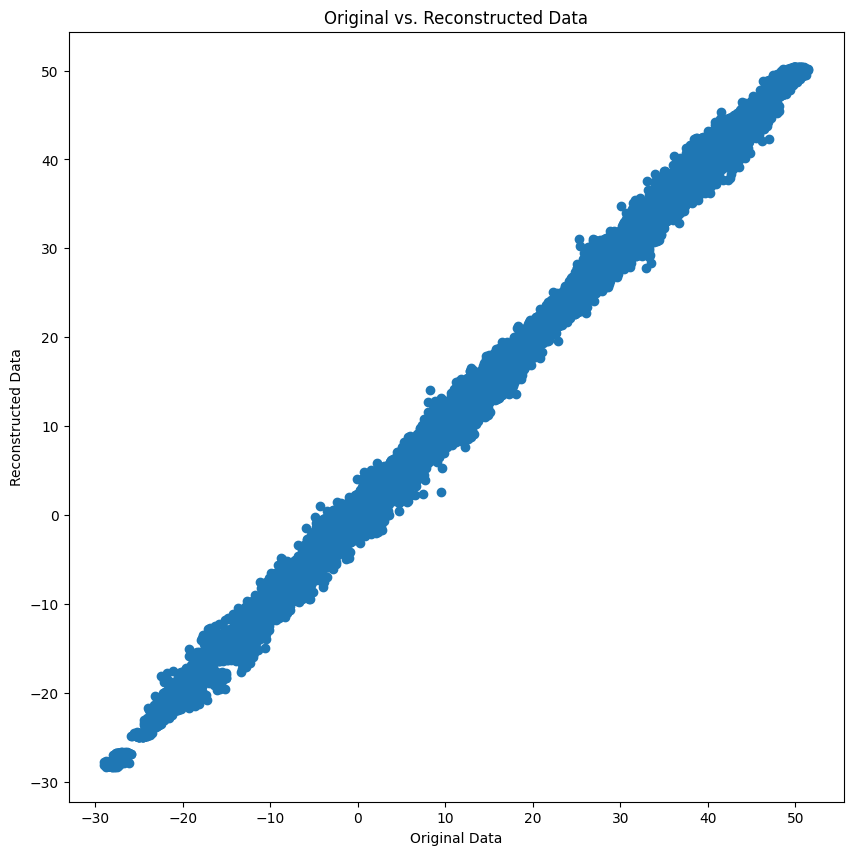

In [83]:
fig = plt.figure(figsize=(10, 10))
plt.scatter(traj_apo.xyz.flatten().flatten()[::1000], x.flatten().flatten()[::1000])
plt.xlabel('Original Data')
plt.ylabel('Reconstructed Data')
plt.title('Original vs. Reconstructed Data')
plt.show()

In [88]:
# Clusters
import pickle

y_pred = np.argmax(qy, axis=1)
y_unq = np.unique(y_pred)
print(y_unq)
for i in range(len(y_unq)):
    y_pred[np.where(y_pred == y_unq[i])] = np.arange(0, len(y_unq))[i]

values, counts = np.unique(y_pred, return_counts=True)
percentages = dict(zip(y_unq, np.round(100*counts/len(y_pred), 2)))
indices_dict = {key: np.where(y_pred == key)[0].tolist() for key in y_unq}
cluster_data = {key: {'percentage': percentages[key], 'frames': indices_dict[key]} for key in y_unq}


print("GMVAE Clustering Results:\n")
print("Overview:")
print("  Number of Clusters: ", len(y_unq))
print("  Cluster Indices: ", (y_unq))
print("")
print("Cluster Population:")
for key, value in percentages.items():
    print(f"  {key}: {value:.2f} %")

[1 2 3 4]
GMVAE Clustering Results:

Overview:
  Number of Clusters:  4
  Cluster Indices:  [1 2 3 4]

Cluster Population:
  1: 14.34 %
  2: 44.49 %
  3: 10.26 %
  4: 30.91 %


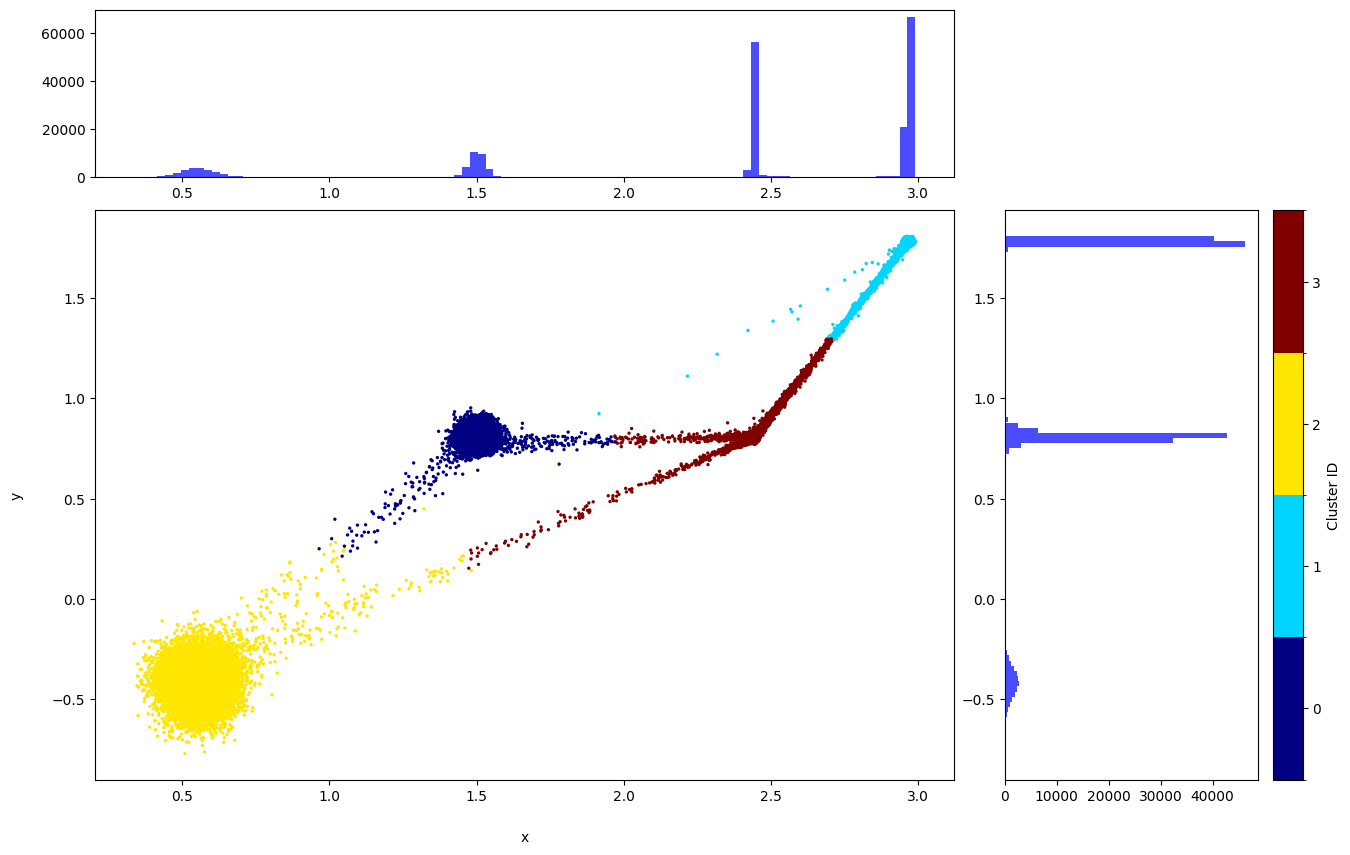

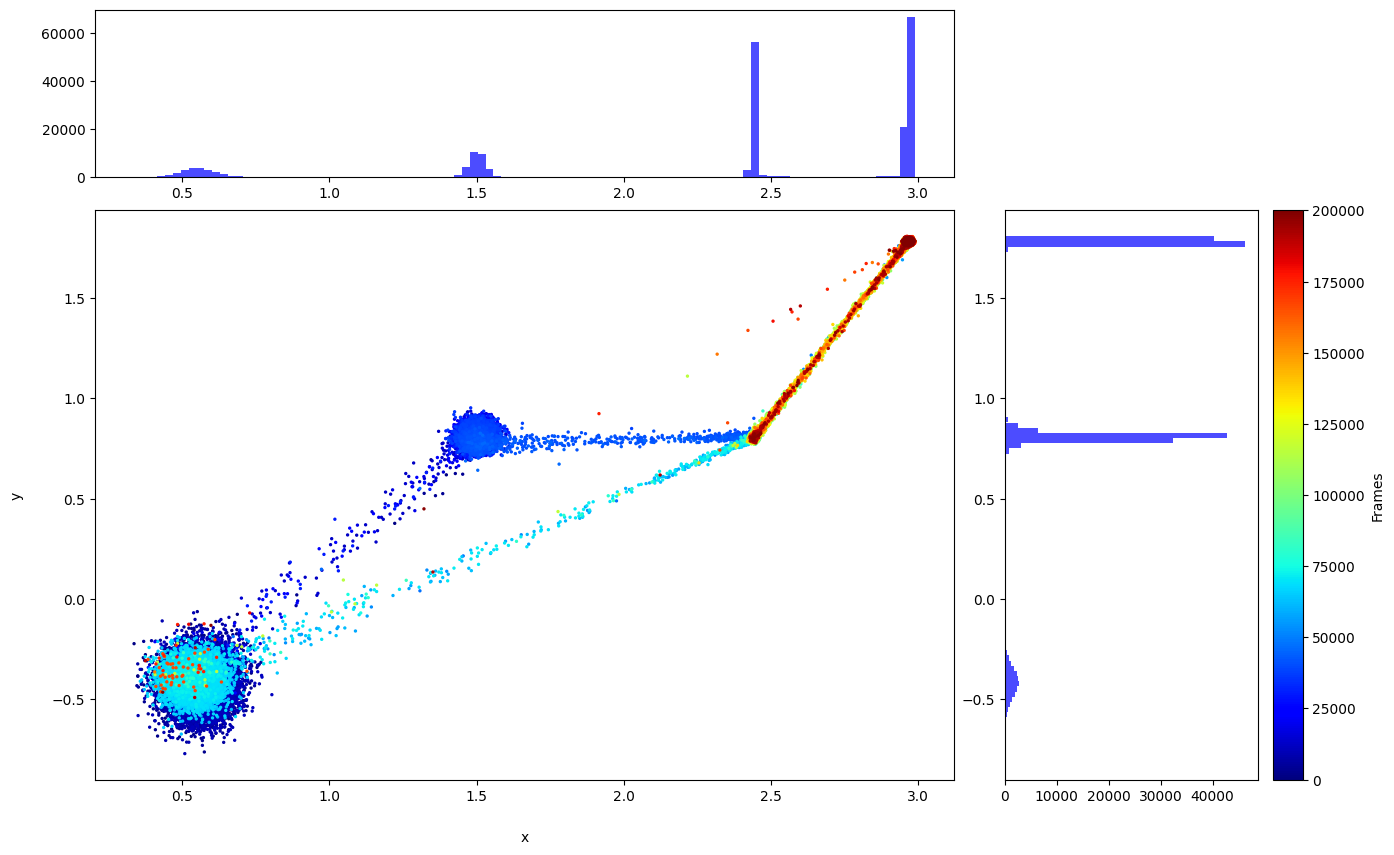

In [87]:
# Latent Space Representation

def plot_latent_space(z, y_pred, mode="by_clusters"):
    gs = gridspec.GridSpec(4, 4)
    fig = plt.figure(figsize=(15, 10))

    ax_main = plt.subplot(gs[1:4, :3])
    ax_xDist = plt.subplot(gs[0, :3], sharex=ax_main)
    ax_yDist = plt.subplot(gs[1:4, 3], sharey=ax_main)

    if mode == "by_frames":
        sc = ax_main.scatter(z[::1, 0], z[::1, 1], c=np.arange(len(z)), alpha=1, cmap='jet', s=2)
    elif mode == "by_clusters":
        y_unq = np.unique(y_pred)
        cmap = plt.get_cmap('jet', len(y_unq))
        boundaries = np.arange(len(y_unq)+1) - 0.5
        norm = BoundaryNorm(boundaries, cmap.N, clip=True)
        sc = ax_main.scatter(z[::1, 0], z[::1, 1], c=y_pred, norm=norm, cmap=cmap, alpha=1, s=2)

    # Position and size of colorbar based on ax_yDist
    pos = ax_yDist.get_position()
    cbar_ax = fig.add_axes([pos.x1 + 0.01, pos.y0, 0.02, pos.height])
    cbar = plt.colorbar(sc, cax=cbar_ax, ticks=np.arange(len(y_unq)) if mode == "by_clusters" else None)
    cbar.set_label('Frames' if mode == "by_frames" else 'Cluster ID')

    # X-axis marginal distribution
    ax_xDist.hist(z[::1, 0], bins=100, color='blue', alpha=0.7)

    # Y-axis marginal distribution
    ax_yDist.hist(z[::1, 1], bins=100, color='blue', alpha=0.7, orientation='horizontal')

    ax_main.set_xlabel('x', labelpad=20)
    ax_main.set_ylabel('y', labelpad=20)

    plt.show()

plot_latent_space(z, y_pred, mode="by_clusters")
plot_latent_space(z, y_pred, mode="by_frames")

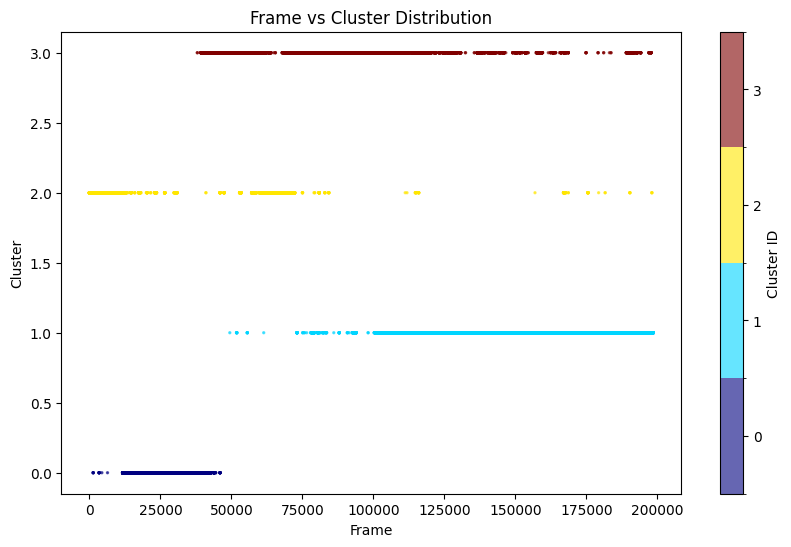

In [84]:
# Cluster Distribution over Time

gs = gridspec.GridSpec(1, 1)
fig = plt.figure(figsize=(10, 6))

ax_main = plt.subplot(gs[0, 0])

# Scatter plot
cmap = plt.get_cmap('jet', len(y_unq))
boundaries = np.arange(len(y_unq)+1) - 0.5
norm = BoundaryNorm(boundaries, cmap.N, clip=True)
sc = ax_main.scatter(np.arange(len(y_pred)), y_pred, c=y_pred, cmap=cmap, norm=norm, s=2, alpha=0.6)

# Labels and title
ax_main.set_xlabel('Frame')
ax_main.set_ylabel('Cluster')
ax_main.set_title(f'Frame vs Cluster Distribution')

# Colorbar
cbar = plt.colorbar(sc, ticks=np.arange(len(y_unq)))
cbar.set_label('Cluster ID')
plt.show()

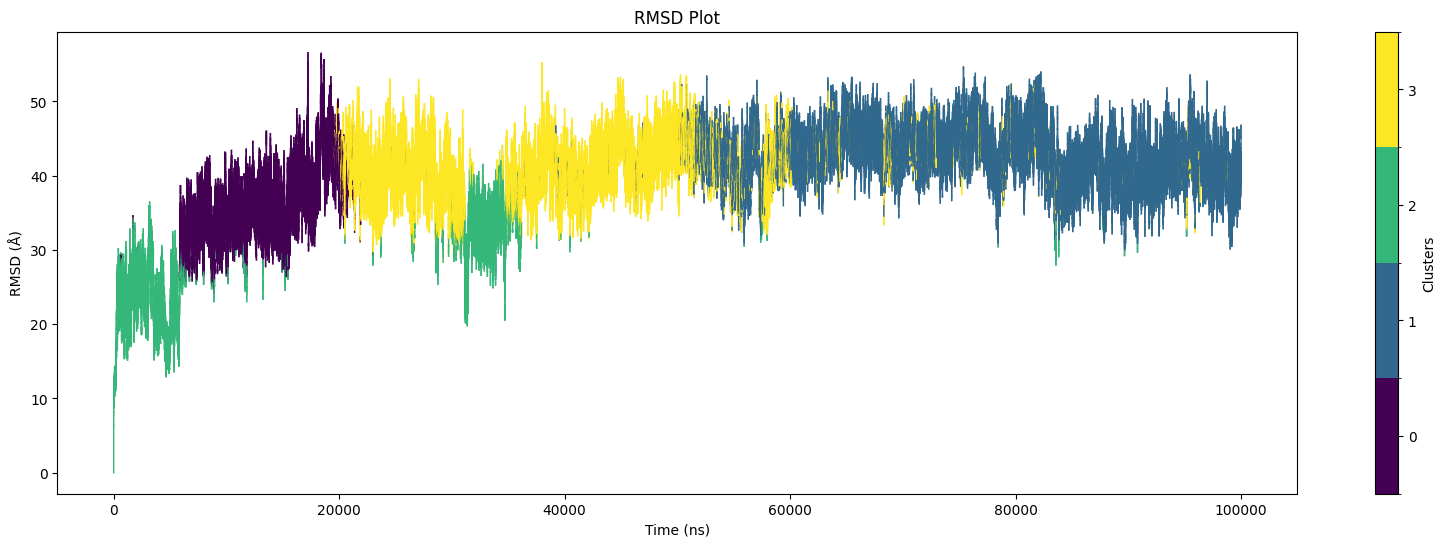

In [89]:
# Clusters on RMSD

def calculate_rmsd(reference, trajectory):
    diff = reference - trajectory
    return np.sqrt(np.mean(np.sum(diff ** 2, axis=1), axis=1))

def RMSD_clustering(y_pred, trajectory_data, moving_av="off"):
    # Create the reference trajectory
    reference = trajectory_data[0]

    # Compute RMSD
    rmsd = calculate_rmsd(reference, trajectory_data)

    # Generate time array (assuming 0.5 ns per frame)
    time = np.arange(len(rmsd)) * 0.5

    # Compute the moving average with a window of 10 ns (20 frames)
    window_size = 5
    moving_avg = np.convolve(rmsd, np.ones(window_size)/window_size, mode='valid')
    moving_avg_time = time[:len(moving_avg)]

    # Create the plot
    fig, ax = plt.subplots(figsize=(20, 6))

    # Find unique values in y_pred and sort them
    y_unq = np.unique(y_pred)
    cmap = plt.get_cmap('viridis', len(y_unq))
    boundaries = np.arange(len(y_unq)+1) - 0.5
    norm = BoundaryNorm(boundaries, cmap.N, clip=True)

    # Plot RMSD over time as a line plot
    for i in range(1, len(time)):
        color_index = np.where(y_unq == y_pred[i-1])[0][0]
        ax.plot(time[i-1:i+1], rmsd[i-1:i+1], color=cmap(color_index), linewidth=1)

    # Plot the moving average
    if moving_av == "on":
        ax.plot(moving_avg_time, moving_avg, 'r', linewidth=0.5, label='Moving Average')

    # Labels and title
    ax.set_xlabel('Time (ns)')
    ax.set_ylabel('RMSD (Å)')
    plt.title('RMSD Plot')

    # Create discrete colorbar
    cbar = plt.colorbar(plt.cm.ScalarMappable(cmap=cmap, norm=norm), ax=ax)
    cbar.set_label('Clusters')

    # Setting tick positions and labels for colorbar
    cbar.set_ticks(np.arange(len(y_unq)))
    cbar.set_ticklabels(y_unq)

    # Show the plot
    plt.show()

RMSD_clustering(y_pred, traj_apo.xyz, moving_av="off")